# Playground

## Config

In [1]:
from pathlib import Path

ROOT_DIR = Path("..").resolve()
DATASET_DIR = ROOT_DIR / "data" / "lsa64_preprocessed_hand_videos"

In [16]:
from recognizer.utils.utils import get_metadata_from_filename

In [17]:
import os
from pathlib import Path

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR):
    if "left" in file:
        continue

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR / file).resolve()))

In [18]:
import pandas as pd 

metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata.head()

,target,subject,repetition,file
0,064,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
2,033,009,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...


## Dataset

In [4]:
from recognizer.dataset import VideoDataset

In [19]:
dataset = VideoDataset(video_filenames=files, labels=targets)

len(dataset)

3200

Since our dataset is composed by videos, we draw the first frame of each of them

### Visualizing some elements

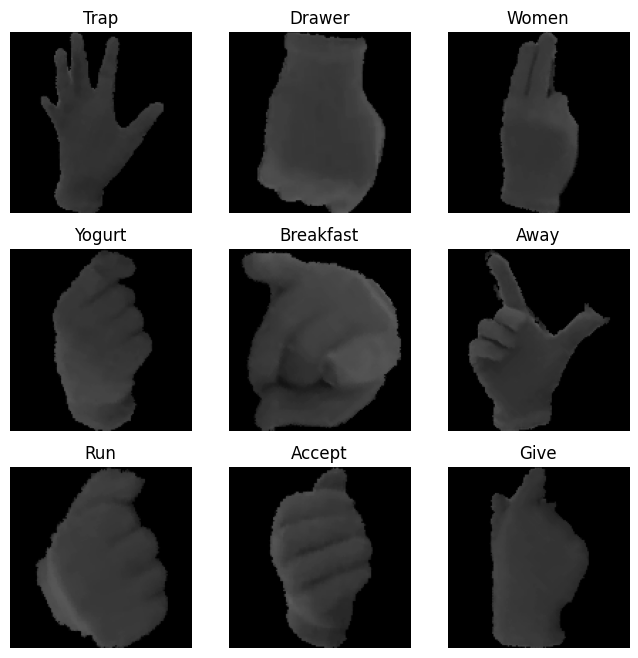

In [21]:
from recognizer.utils.constants import LABELS_MAP
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABELS_MAP[label])
    plt.axis("off")
    plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

## Dataloader

From Pytorch documentation:

>The Dataset retrieves our dataset’s features and labels one sample at a time. 


>While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

The following cell throws an error because pytorch is not able to stack all the elements accordingly. This is due to the elements having different size, because the videos have different amount of frames.

In [1]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0][0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")

NameError: name 'train_dataloader' is not defined

## Number of frames

Each video has different number of frames. We have to conciliate this

In [30]:
sizes = []

for element in dataset:
    sizes.append(element[0].shape[0])

sizes = pd.Series(data=sizes)

In [34]:
pd.DataFrame(
    [sizes.describe(percentiles=[.1, .25, .5, .75, .9, .99])]
)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
0,3200.0,82.759687,27.580784,14.0,50.0,65.0,78.0,100.0,118.0,159.0,201.0


Looks like some videos only have **14** frames, whereas others have up to **201**. 

Somehow, we have to conciliate this

## Transform

Should I do some transformation in the dataset? 

What about labels? Do I need to provide them as one hot to torch?

## Device

We select a hardware accelerator to train the model if possible.

In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


## Build the model

Here I will code the 3D-CNN